## miary dystrybucyjne i typu wordnet

### importy i przygotowanie środowiska


In [1]:
!pip3 install --index-url https://pypi.clarin-pl.eu/simple/ plwn-api

Looking in indexes: https://pypi.clarin-pl.eu/simple/


In [2]:
import plwn
import numpy as np
import scipy as sc
import scipy.spatial
import os
import pandas as pd
import math
from collections import OrderedDict
from tqdm.notebook import tqdm
import seaborn as sns

In [3]:
import sys
print(sys.getrecursionlimit())

1000


#### pobranie danych


In [4]:
# # not always working:
# if not os.path.exists('default_model'):
#     res = plwn.download()
# wn = plwn.load("default_model")

from google.colab import drive
drive.mount('/content/gdrive')
wn = plwn.load("/content/gdrive/My Drive/datasets/default_model")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#download the embeddings if not already there:
if not os.path.exists('./nkjp+wiki-lemmas-all-100-cbow-hs.txt'):
    if not os.path.exists('./nkjp+wiki-lemmas-all-100-cbow-hs.txt.gz'):
        !wget http://dsmodels.nlp.ipipan.waw.pl/dsmodels/nkjp+wiki-lemmas-all-100-cbow-hs.txt.gz
    !gzip -d nkjp+wiki-lemmas-all-100-cbow-hs.txt.gz
# if not os.path.exists('./nkjp+wiki-forms-all-100-cbow-hs.txt'):
#     if not os.path.exists('./nkjp+wiki-forms-all-100-cbow-hs.txt.gz'):
#         !wget http://dsmodels.nlp.ipipan.waw.pl/dsmodels/nkjp+wiki-forms-all-100-cbow-hs.txt.gz
#     !gzip -d nkjp+wiki-forms-all-100-cbow-hs.txt.gz
# if not os.path.exists('./kgr10.plain.skipgram.dim100.neg10.vec'):
#     !wget "https://nextcloud.clarin-pl.eu/index.php/s/luubhnS0AvjmtQc/download?path=%2F&files=kgr10.plain.skipgram.dim100.neg10.vec" -O kgr10.plain.skipgram.dim100.neg10.vec

#
if not os.path.exists('./MSimLex999_Polish.txt'):
    if not os.path.exists('./MSimLex999_Polish.zip'):
        !wget "http://zil.ipipan.waw.pl/CoDeS?action=AttachFile&do=get&target=MSimLex999_Polish.zip" -O MSimLex999_Polish.zip
    !unzip MSimLex999_Polish.zip

### komparatory ocen podobieństwa

In [6]:
def levenshteinDistance(s1, s2): # unused
    #https://stackoverflow.com/a/32558749
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def HeuricticScoringMetric(s1, s2):
    #s1, s2 must be sorted pandas.Series objects
    s2_val = s2.iloc[0]
    score = 0
    for s1_idx, s1_val in s1.items():
        s2_next_val = s2.loc[s1_idx]
        if s2_next_val >= s2_val:
            score += 1
        s2_val = s2_next_val
    return score

### miary na słowosieci

#### Wu-Palmer

In [7]:
def get_hipos(synset):
    # returns list of synset hyponyms
    parent_synsets = []
    for relation, synset in synset.related_pairs():
        if relation.name == 'hiponimia':
            parent_synsets.append(synset)
    return parent_synsets

def hipo_tree(synset):
    # recurrent tree of hyponyms (pl.: hiponom)
    #  (synset [                                               ])
    #           (synset [                              ]), ...
    #                    (synset [...]), (synset [...])
    return (synset, [ hipo_tree(s) 
            for s in get_hipos(synset)] )

def hipo_tree_to_lvl_list(tree, lvl=0):
    # turns hipo_tree into flat list 
    # with info about the distance from root
    result = [(lvl, tree[0])]
    parents = [hipo_tree_to_lvl_list(parents, lvl=lvl+1) for parents in tree[1]]
    for ps in parents:
        result += ps
    return result

def hipo_tree_to_lvl_leafs(tree, lvl=0):
    # level and synset - as above,
    # but only leafs returned
    result = [lvl] if (len(tree[1]) == 0) else []
    parents = [hipo_tree_to_lvl_leafs(parents, lvl=lvl+1) for parents in tree[1]]
    for ps in parents:
        result += ps
    return result

def syns_depth(syns):
    # the total depth of synsetu
    return min(hipo_tree_to_lvl_leafs(hipo_tree(syns)))

def LCS(sa, sb, artificial_root=True):
    hla = hipo_tree_to_lvl_list(hipo_tree(sa))
    hlb = hipo_tree_to_lvl_list(hipo_tree(sb))
    
    dist_a, dist_b = 99999, 99999
    idx_i, idx_j = -1, -1
    for i in range(len(hla)):
        mid_res = []
        for j in range(len(hlb)):
            if hla[i][1].short_str() == hlb[j][1].short_str():
                if hla[i][0] + hlb[j][0] < dist_a + dist_b:
                    dist_a, dist_b = hla[i][0], hlb[j][0]
                    idx_i, idx_j = i, j
    
    lcs = hla[idx_i][1] if (idx_i != -1) else None #None also represents an artificial root
    if artificial_root:
        if lcs is None:
            dist_a = syns_depth(sa) + 1
            dist_b = syns_depth(sb) + 1
    return lcs, dist_a, dist_b
    
def WP(lex_a, lex_b, artificial_root=True):
    # https://www.mitpressjournals.org/doi/pdf/10.1162/coli.2006.32.1.13
    # page 19
    sa = lex_a.synset
    sb = lex_b.synset
    lcs_synset, a2lcs_dist, b2lcs_dist = LCS(sa, sb, artificial_root)
    if lcs_synset is None:
        # no LCS found - artificial root necessary
        d = 0
    else:
        # measure the lcs depth
        d = syns_depth(lcs_synset) + int(artificial_root)
    return 2 * d / (a2lcs_dist + b2lcs_dist + 2 * d)

#### Leacock and Chodorow’s Normalized Path Length

In [8]:
def ModifiedNormalizedPathLength(lex_a, lex_b):
    # modified Leacock and Chodorow’s Normalized Path Length
    # modified here means rescaled (max_wn_depth was not measured)
    # scoring monotony is perserved
    sa = lex_a.synset
    sb = lex_b.synset
    lcs_synset, a2lcs_dist, b2lcs_dist = LCS(sa, sb)
    len_a_b = a2lcs_dist + b2lcs_dist
    max_wn_depth = 20
    return -math.log(len_a_b/max_wn_depth)

#### obie miary łącznie (bez dublowania obliczeń)

In [9]:
def WordnetMetrics(lex_a, lex_b):
    # modified Leacock and Chodorow’s Normalized Path Length
    # modified here means rescaled (max_wn_depth was not measured)
    # scoring monotony is perserved
    sa = lex_a.synset
    sb = lex_b.synset
    lcs_synset, a2lcs_dist, b2lcs_dist = LCS(sa, sb)
    len_a_b = a2lcs_dist + b2lcs_dist
    if len_a_b == 0: # log(0) would throw an error
        len_a_b = 1
    max_wn_depth = 20

    #Wu Palmer
    artificial_root = True
    if lcs_synset is None:
        # no LCS found - artificial root necessary
        d = 0
    else:
        # measure the lcs depth
        d = syns_depth(lcs_synset) + int(artificial_root)
    return {'wu_palmer': 2 * d / (a2lcs_dist + b2lcs_dist + 2 * d),
            'normalized_path_length': -math.log(len_a_b/max_wn_depth)}

### klasa licząca odległości/podobieństwa

In [10]:
class DistanceCalculator():
    def __init__(self,
                #  filepaths_to_embeddings={'waw_embed':'nkjp+wiki-lemmas-all-100-cbow-hs.txt',
                #                           'wro_embed':'kgr10.plain.skipgram.dim100.neg10.vec'},
                 filepaths_to_embeddings={'embed':'nkjp+wiki-lemmas-all-100-cbow-hs.txt'},
                 wordnet=wn,
                 ):
        self.embeddings_dicts = {
            key:self.embedings_from_file(path)
            for key, path in filepaths_to_embeddings.items()
        }
        self.wordnet = wn

    def simlex_eval(self, simlex_path='MSimLex999_Polish.txt'):
        simlex_pl = pd.read_csv(simlex_path, sep='\t', index_col='idx',
                                names=['idx','word1','word2','similarity','relatedness'])
        distances = []
        indexes = []
        for i, row in tqdm(simlex_pl.iterrows()):
            try:
                d = dc.calculate_distances(row.word1, row.word2)
            except KeyError:
                print(f'info: one of keys ({row.word1}, {row.word2}) not found in dictionary')
                continue
            except IndexError:
                print(f'info: one of keys ({row.word1}, {row.word2}) not found in wordnet')
            except RecursionError:
                print(f'RecursionError given keys: ({row.word1}, {row.word2})')
            distances.append(d)
            indexes.append(i)
        distances = pd.DataFrame(distances)
        distances.set_index(pd.Index(indexes, name='idx'))
        self.simlex_pl = simlex_pl.merge(distances, left_index=True, right_index=True)
        return self.list_distances(self.simlex_pl.drop(columns=['word1','word2']))

    def list_distances(self, pd_metrics):
        #levenshteinDistance:
        M = len(pd_metrics.columns)
        score_matrix = [[None]*M for i in range(M)]
        for i, c1 in enumerate(pd_metrics.columns):
            for j, c2 in enumerate(pd_metrics.columns):
                score_matrix[i][j] = HeuricticScoringMetric(pd_metrics[c1].sort_values(), 
                                                            pd_metrics[c2].sort_values())
        return pd.DataFrame(score_matrix, index=pd_metrics.columns, columns=pd_metrics.columns)

    def embedings_from_file(self, path):
        embeddings = {}
        print(f'reading file {path} ...')
        with open(path) as f:
            for line in tqdm(f):
                word, coefs = line.split(maxsplit=1)
                coefs = np.fromstring(coefs, "f", sep=" ")
                embeddings[word] = coefs
        return embeddings

    def cosine_similarity(self, wordA, wordB, embeddings):
        return sc.spatial.distance.cosine(embeddings[wordA], embeddings[wordB])

    def l2_similarity(self, wordA, wordB, embeddings):
        return np.linalg.norm(embeddings[wordA] - embeddings[wordB])

    def distribution_distances(self, wordA, wordB):
        result = {}
        for dictionary_name, embeddings in self.embeddings_dicts.items():
            result.update({
                f'cosine_distance_{dictionary_name}': self.cosine_similarity(wordA, wordB, embeddings),
                f'euclidean_distance_{dictionary_name}': self.l2_similarity(wordA, wordB, embeddings),
            })
        return result

    def wordnet_distances(self, wordA, wordB):
        result = {}
        wordA = self.wordnet.lexical_units(wordA)[0]
        wordB = self.wordnet.lexical_units(wordB)[0]
        metrics = WordnetMetrics(wordA, wordB)
        result.update({
            f'wordnet_Wu-Palmer': metrics['wu_palmer'],
            f'wordnet_NormalizedPathLength': metrics['normalized_path_length'],
        })
        return result

    def calculate_distances(self, wordA, wordB):
        result = {}
        result.update(self.wordnet_distances(wordA, wordB))
        result.update(self.distribution_distances(wordA, wordB))
        return result

    def get_K_closest_to_wordA_from_list(self, wordA, list_of_words, K=5):
        results = {}
        for wordB in tqdm(list_of_words):
            try:
                distances = self.calculate_distances(wordA, wordB)
            except KeyError:
                print(f'info: one of keys ({wordA}, {wordB}) not found in dictionary')
                continue
            except IndexError:
                print(f'info: one of keys ({wordA}, {wordB}) not found in wordnet')
            except RecursionError:
                print(f'RecursionError given keys: ({wordA}, {wordB})')
            results[wordB] = distances
        pd_results = pd.DataFrame(results).T
        result = {}
        for metric, all_distances in pd_results.items():
            result[metric] = all_distances.sort_values()[:K].to_dict(into=OrderedDict)
        return result

## obserwacje

In [11]:
dc = DistanceCalculator()

reading file nkjp+wiki-lemmas-all-100-cbow-hs.txt ...


In [12]:
dc.calculate_distances('kot','pies')

{'cosine_distance_embed': 0.15627360343933105,
 'euclidean_distance_embed': 8.467666,
 'wordnet_NormalizedPathLength': 2.3025850929940455,
 'wordnet_Wu-Palmer': 0.8571428571428571}

In [13]:
dc.calculate_distances('kot','lodówka')

{'cosine_distance_embed': 0.6711545884609222,
 'euclidean_distance_embed': 17.376816,
 'wordnet_NormalizedPathLength': 0.4307829160924542,
 'wordnet_Wu-Palmer': 0.23529411764705882}

In [14]:
dc.calculate_distances('pływać','różowy')

{'cosine_distance_embed': 0.8321841508150101,
 'euclidean_distance_embed': 19.901152,
 'wordnet_NormalizedPathLength': 1.2039728043259361,
 'wordnet_Wu-Palmer': 0.0}

info: one of keys (przestraszony, zalękniony) not found in dictionary
info: one of keys (obładowany, ciężki) not found in wordnet
info: one of keys (niedawny, nowy) not found in wordnet
info: one of keys (głupi , rzadki) not found in wordnet
info: one of keys (pieniądze, pensja) not found in dictionary
info: one of keys (łódź, kotwica) not found in dictionary
info: one of keys (łódź, pokład) not found in dictionary
info: one of keys (ubrania, szuflada) not found in wordnet
info: one of keys (pieniądze, kapitał) not found in dictionary
info: one of keys (łódź, samochód) not found in dictionary
info: one of keys (dąb , klon) not found in wordnet
info: one of keys (nasiona, musztarda) not found in wordnet
info: one of keys (silnik, łódź) not found in dictionary
info: one of keys (mężczyźni, bractwo) not found in wordnet
info: one of keys (mieszkanie, meble) not found in wordnet
info: one of keys (populacja, ludzie) not found in dictionary
info: one of keys (zaprzeczenie, spowiedż) not fou

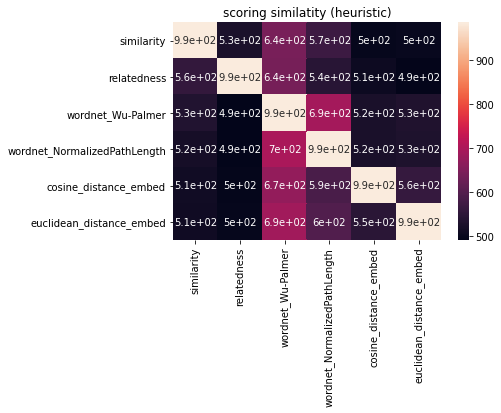

In [15]:
most_simillar_metrics = dc.simlex_eval('MSimLex999_Polish.txt')
sns.heatmap(most_simillar_metrics, annot=True).set(title='scoring similatity (heuristic)');

In [16]:
setA = !awk '{print $2}' MSimLex999_Polish.txt
setB = !awk '{print $3}' MSimLex999_Polish.txt
tiny_corpus = set(setA) | set(setB)

In [17]:
dc.get_K_closest_to_wordA_from_list('bystry', tiny_corpus, K=10)

RecursionError given keys: (bystry, deklarować)
RecursionError given keys: (bystry, odkładać)
RecursionError given keys: (bystry, posiąść)
RecursionError given keys: (bystry, aranżować)
info: one of keys (bystry, mężczyźni) not found in wordnet
RecursionError given keys: (bystry, przyjść)
info: one of keys (bystry, pojawiać) not found in wordnet
RecursionError given keys: (bystry, spełnić)
RecursionError given keys: (bystry, dać)
RecursionError given keys: (bystry, zbierać)
RecursionError given keys: (bystry, zabawiać)
info: one of keys (bystry, obładowany) not found in wordnet
RecursionError given keys: (bystry, przynosić)
RecursionError given keys: (bystry, zbadać)
RecursionError given keys: (bystry, grać)
RecursionError given keys: (bystry, wyglądać)
RecursionError given keys: (bystry, udusić)
RecursionError given keys: (bystry, zawitać)
RecursionError given keys: (bystry, ukraść)
RecursionError given keys: (bystry, zdobyć)
RecursionError given keys: (bystry, zlokalizować)
Recursion

{'cosine_distance_embed': OrderedDict([('bystry', 0.0),
              ('chłopiec', 0.6090092957019806),
              ('usposobienie', 0.6341421008110046),
              ('gniewny', 0.644877701997757),
              ('zalękniony', 0.6508411467075348),
              ('pogoda', 0.6550817787647247),
              ('chłopak', 0.6673302054405212),
              ('dziewczyna', 0.6772406697273254),
              ('szałas', 0.7002425193786621),
              ('opowieść', 0.7058223783969879)]),
 'euclidean_distance_embed': OrderedDict([('bystry', 0.0),
              ('zalękniony', 14.839924812316895),
              ('koncept', 15.128437995910645),
              ('ogar', 15.193888664245605),
              ('zgraja', 15.26916217803955),
              ('głupol', 15.381369590759277),
              ('gin', 15.476540565490723),
              ('wielkoduszny', 15.702993392944336),
              ('prędki', 15.719139099121094),
              ('chytry', 15.763794898986816)]),
 'wordnet_NormalizedPathLengt